# Assignment 1

### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [1]:
%matplotlib inline
import warnings

from dataclasses import dataclass
import torch
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
from utils import seed_experiment, to_device, cross_entropy_loss, compute_accuracy
from config import get_config_parser
import json
from utils import save_gradient
from mlp import MLP
from resnet18 import ResNet18
from mlpmixer import MLPMixer
from tqdm import tqdm
from torch.utils.data import DataLoader
import time

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"


# Local Test
Before run the experiment, here are some local test cases you can run for sanity check

In [2]:
import unittest
import test
suite = unittest.TestLoader().loadTestsFromModule(test)
unittest.TextTestRunner(verbosity=2).run(suite)

test_linear_attributes (test.TestLinear) ... ok
test_linear_forward (test.TestLinear) ... ok
test_activation (test.TestMLP) ... ok
test_forward (test.TestMLP) ... ok
test_mlp (test.TestMLP) ... ok
test_mixer_block (test.TestMLPMixer) ... ok
test_mlpmixer (test.TestMLPMixer) ... ok
test_patch_emb (test.TestMLPMixer) ... ok
test_basic_block (test.TestResNet) ... ok
test_basic_block2 (test.TestResNet) ... ok
test_resnet (test.TestResNet) ... ok
test_ce_loss (test.TestUtils) ... ok

----------------------------------------------------------------------
Ran 12 tests in 0.360s

OK


<unittest.runner.TextTestResult run=12 errors=0 failures=0>

## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main_entry()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularizations).

In [3]:
@dataclass
class Arguments:
  # Data
  batch_size: int = 128
  # Model
  model: str = 'mlp'  # [mlp, resnet18, mlpmixer]
  model_config: str = "./model_configs/mlp.json" # path to model config json file

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 15
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  logdir: str = '/content/assignment/logs'
  seed: int = 42
  

  # Miscellaneous
  device: str = 'cuda'
  visualize : bool = False
  print_every: int = 80

In [4]:
layer_dict = {}

In [5]:
# Main code entry. Train the model and save the logs
from main import train, evaluate
def main_entry(args):
    # Check for the device
    if (args.device == "cuda") and not torch.cuda.is_available():
        warnings.warn(
            "CUDA is not available, make that your environment is "
            "running on GPU (e.g. in the Notebook Settings in Google Colab). "
            'Forcing device="cpu".'
        )
        args.device = "cpu"

    if args.device == "cpu":
        warnings.warn(
            "You are about to run on CPU, and might run out of memory "
            "shortly. You can try setting batch_size=1 to reduce memory usage."
        )

    # Seed the experiment, for repeatability
    seed_experiment(args.seed)

    test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
    # For training, we add some augmentation. Networks are too powerful and would overfit.
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                        ])
    # Loading the training dataset. We need to split it into a training and validation part
    # We need to do a little trick because the validation set should not use the augmentation.
    train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    val_dataset = CIFAR10(root='./data', train=True, transform=test_transform, download=True)
    train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
    _, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

    # Loading the test set
    test_set = CIFAR10(root='./data', train=False, transform=test_transform, download=True)
    
    # Load model
    print(f'Build model {args.model.upper()}...')
    if args.model_config is not None:
        print(f'Loading model config from {args.model_config}')
        with open(args.model_config) as f:
            model_config = json.load(f)
    else:
        raise ValueError('Please provide a model config json')
    print(f'########## {args.model.upper()} CONFIG ################')
    for key, val in model_config.items():
        print(f'{key}:\t{val}')
    print('############################################')
    model_cls = {'mlp': MLP, 'resnet18': ResNet18, 'mlpmixer': MLPMixer}[args.model]
    model = model_cls(**model_config)
    model.to(args.device)
    
    # Optimizer
    if args.optimizer == "adamw":
        optimizer = optim.AdamW(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "momentum":
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum,
            weight_decay=args.weight_decay,
        )
    
    print(
        f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
        
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )
    totalparam = [sum(p.numel() for p in model.parameters() if p.requires_grad)]

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    train_times, valid_times = [], []
    
    # We define a set of data loaders that we can use for various purposes later.
    train_dataloader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    valid_dataloader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    test_dataloader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    for epoch in range(args.epochs):
        tqdm.write(f"====== Epoch {epoch} ======>")
        loss, acc, wall_time = train(epoch, model, train_dataloader, optimizer,args)
        save_gradient(model, layer_dict, epoch, total_epochs=args.epochs)
        train_losses.append(loss)
        train_accs.append(acc)
        train_times.append(wall_time)

        loss, acc, wall_time = evaluate(epoch, model, valid_dataloader,args)
        valid_losses.append(loss)
        valid_accs.append(acc)
        valid_times.append(wall_time)

    test_loss, test_acc, test_time = evaluate(
        epoch, model, test_dataloader, args, mode="test"
    )
    print(f"===== Best validation Accuracy: {max(valid_accs):.3f} =====>")


    # Save log if logdir provided
    if args.logdir is not None:
        print(f'Writing training logs to {args.logdir}...')
        os.makedirs(args.logdir, exist_ok=True)
        with open(os.path.join(args.logdir, 'results.json'), 'w') as f:
            f.write(json.dumps(
                {
                    "train_losses": train_losses,
                    "valid_losses": valid_losses,
                    "train_accs": train_accs,
                    "valid_accs": valid_accs,
                    "test_loss": test_loss,
                    "test_acc": test_acc,
                    'train_time':train_times,
                    'test_time':valid_times,
                    'Total_param':totalparam,
                },
                indent=4,
            ))
    
        # Visualize
        if args.visualize and args.model in ['resnet18', 'mlpmixer']:
            model.visualize(args.logdir)


In [6]:

# Example to run MLP with 15 epochs
config = Arguments(model='mlp', 
                   model_config='model_configs/relu.json', 
                   logdir="./model_configs/experiments/gradient/mlp",device=
                   'cuda')
main_entry(config)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLP...
Loading model config from model_configs/relu.json
########## MLP CONFIG ################
input_size:	3072
hidden_sizes:	[1024, 512, 64, 64]
num_classes:	10
activation:	relu
############################################
Initialized MLP model with 3709194 total parameters, of which 3709194 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.45742
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.89899
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.81842
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.52470
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.69663
== [TRAIN] Epoch: 0, Accuracy: 0.361 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.70906
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.427 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.61493
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.62771
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.61733
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.78297
[TRAIN

In [15]:
import numpy as np

np.mean([ 0.6718795299530029,
        0.8020045757293701,
        0.8771941661834717,
        0.656348705291748,
        0.8207492828369141,
        0.7286067008972168,
        0.7356500625610352,
        0.6387743949890137,
        0.9697976112365723,
        0.991797924041748,
        0.7292747497558594,
        1.1258008480072021,
        1.2797927856445312,
        0.7321181297302246,
        0.8144512176513672])

0.8382827123006185

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from model_configs/mlpmixer_patch_size_32.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	32
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 2897678 total parameters, of which 2897678 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 3.27161
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.73390
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.65143
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.77215
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.48992
== [TRAIN] Epoch: 0, Accuracy: 0.375 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.68339
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.424 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.65748
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.64277
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.4

AttributeError: 'Axes' object has no attribute 'flatten'

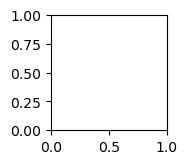

In [10]:
config = Arguments(model='mlpmixer', 
                   model_config='model_configs/mlpmixer_patch_size_32.json', 
                   logdir="model_configs/experiments/mlpmixer/patch_sizes_2/32",
                   visualize=True,
                   epochs=2,
                   device='cuda',
                   )
main_entry(config)

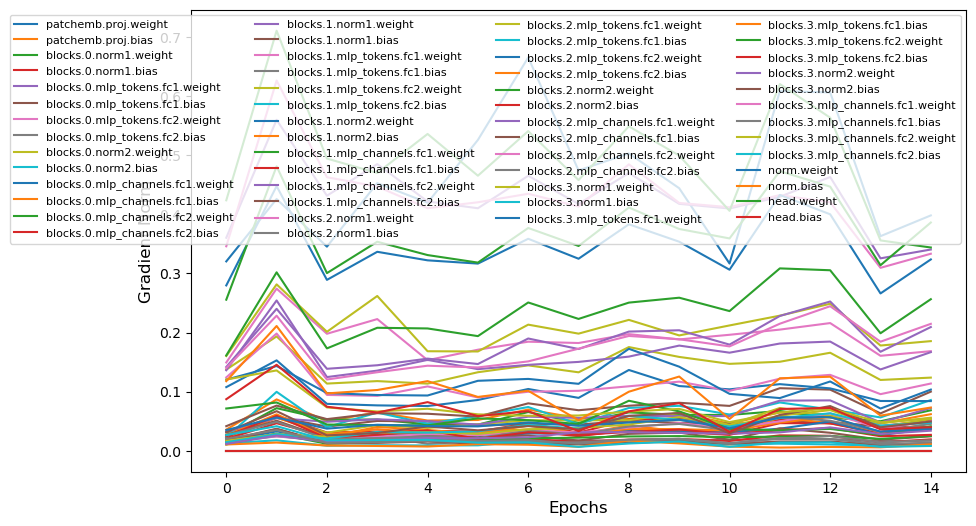

In [7]:
import matplotlib.pyplot as plt
def plot_gradients(layer_dict, save_path='./model_configs/experiments/gradient/figures/mlpmixer.png'):
    plt.figure(figsize=(10, 6))
    handles = []
    labels = []
    
    for layer, grad_values in layer_dict.items():
        grad_array = grad_values.detach().cpu().numpy()  
        line, = plt.plot(range(len(grad_array)), grad_array, label=layer)  
        handles.append(line) 
        labels.append(layer) 

    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Gradient Norm", fontsize=12)
    
    plt.legend(handles, labels,  fontsize=8, frameon=True, markerscale=0.8,ncol=4)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_gradients(layer_dict)

In [8]:
layer_dict.keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.shortcut.0.weight', 'layer2.0.shortcut.1.weight', 'layer2.0.shortcut.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'layer3.0.conv2.weight', 'layer3.0.bn2.weight', 'layer3.0.bn2.bias', 'layer3.0.shortcut.0.weight', 'layer3.0.shortcut.1.weight', 'layer3.0.shortcut.1.bias', 'layer3.1.conv1.weight', 'layer3.1.bn1.weight', 'layer3.1.bn1.bias', 'layer3.1.co

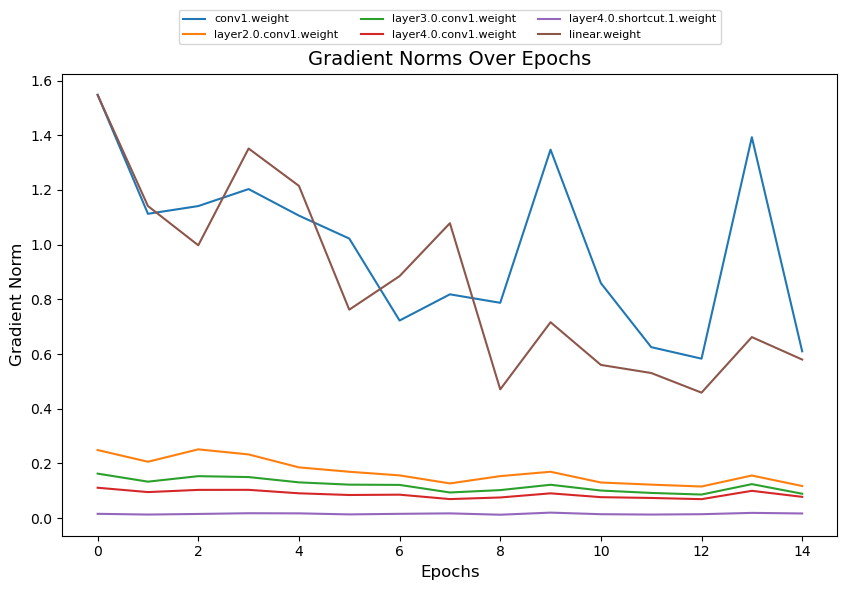

In [9]:
import matplotlib.pyplot as plt
def plot_selected_gradients(layer_dict, selected_layers, save_path='./model_configs/experiments/gradient/figures/resnet18.png'):
    plt.figure(figsize=(10, 6))

    handles = []
    labels = []

    for layer in selected_layers:
        if layer in layer_dict:  # Ensure the layer exists in the dictionary
            grad_array = layer_dict[layer].detach().cpu().numpy()  
            line, = plt.plot(range(len(grad_array)), grad_array, label=layer)  
            handles.append(line)
            labels.append(layer)
        else:
            print(f"Warning: {layer} not found in layer_dict")  # Debugging message

    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Gradient Norm", fontsize=12)
    plt.title("Gradient Norms Over Epochs", fontsize=14)
    
    plt.legend(handles, labels, loc="upper center", fontsize=8, frameon=True, markerscale=0.8, 
               ncol=3, bbox_to_anchor=(0.5, 1.15))  

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

selected_layers = [
    'conv1.weight',  
    'layer2.0.conv1.weight', 
    'layer3.0.conv1.weight',  
    'layer4.0.conv1.weight',
    'layer4.0.shortcut.1.weight',  
    'linear.weight'  
]

plot_selected_gradients(layer_dict, selected_layers)

In [16]:
list(layer_dict.values())[0]

tensor([0.4127, 0.3308, 0.3841, 0.3490, 0.2997, 0.3123, 0.2973, 0.2620, 0.2684,
        0.2741, 0.2853, 0.2871, 0.2724, 0.2593, 0.3017])

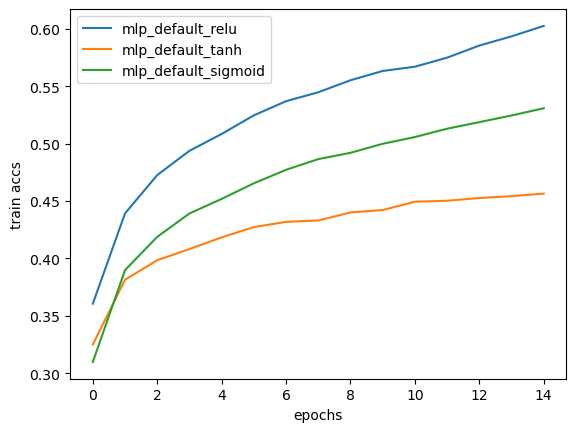

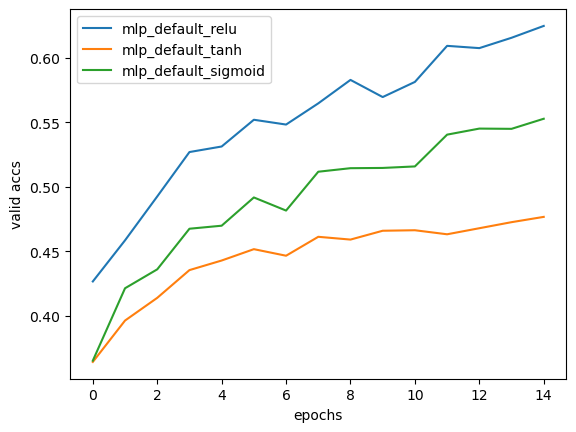

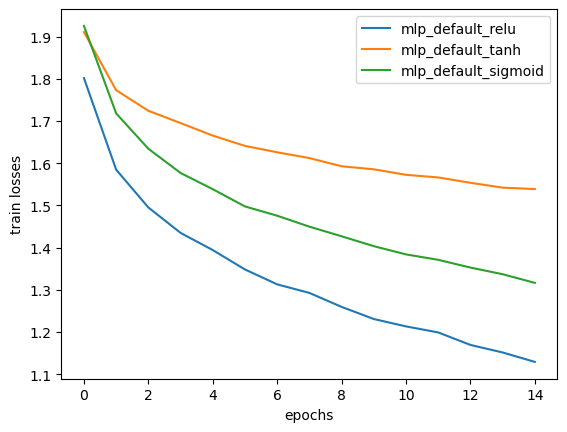

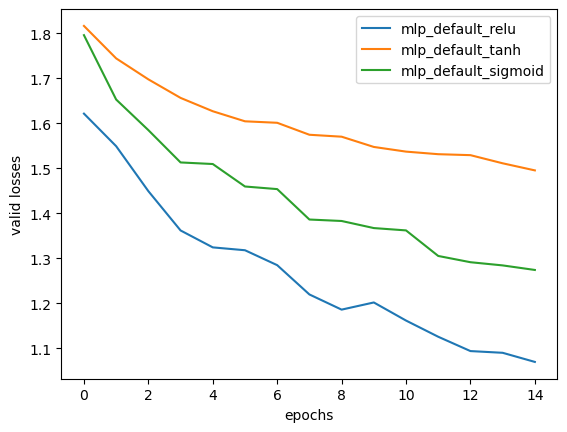

In [19]:

from utils import generate_plots
parent_dir = './exps/'
list_dir = os.listdir(parent_dir)
list_dir = [os.path.join(parent_dir,path) for path in list_dir ]
legends = [os.path.split(directory)[-1] for directory in list_dir]
generate_plots(list_dir,legends,save_path=parent_dir)


./model_configs/experiments/resnet18/resnet18/0.001
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35366
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.51955
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.49549
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.36336
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.23980
== [TRAIN] Epoch: 0, Accuracy: 0.474 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.19638
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.604 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.92196
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.96026
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.98826
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.96704

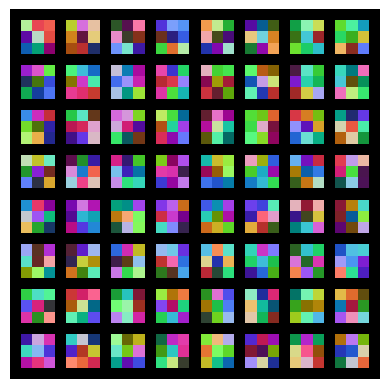

In [6]:
import os
lrs = [0.001]
run_dir = './model_configs/resnet18.json'
parent_dir = './model_configs/experiments/resnet18/resnet18'

for lr in lrs:
    save_dir = os.path.join(parent_dir,str(lr))
    os.makedirs(save_dir,exist_ok=True)
    print(save_dir)

    config = Arguments(
                    model='resnet18', 
                    optimizer='adam',
                    lr=lr,
                    model_config=run_dir, 
                    visualize=True,
                    logdir=save_dir,
                    device='cuda')
    main_entry(config)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35366
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.81508
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.76034
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.59464
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.57646
== [TRAIN] Epoch: 0, Accuracy: 0.337 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.55271
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.431 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.56655
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.29421
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.29489
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.34318
[TRAIN] Epoch: 1, Iter: 320, Loss: 1.13954
== [TRAI

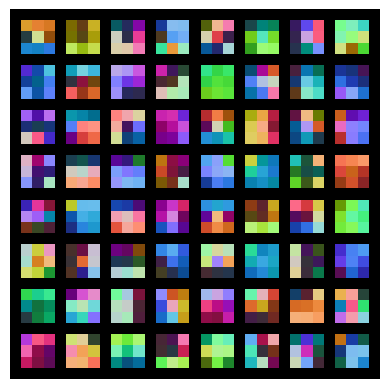

In [9]:
lrs = [0.0001,0.01]
optimizers = ['adam','sgd']
my_lr = lrs[1]
optmizer =optimizers[0] 
run_dir = './model_configs/resnet18.json'
save_dir = f'./model_configs/experiments/resnet18/optimal/lr_{my_lr}_optimizer_{optmizer}'
os.makedirs(save_dir,exist_ok=True)

config = Arguments(
                model='resnet18', 
                optimizer=optmizer,
                lr=my_lr,
                model_config=run_dir, 
                visualize=True,
                logdir=save_dir,
                epochs=20,
                device='cuda')
main_entry(config)


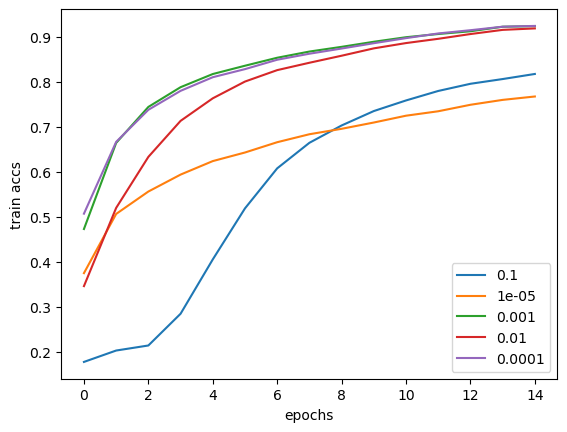

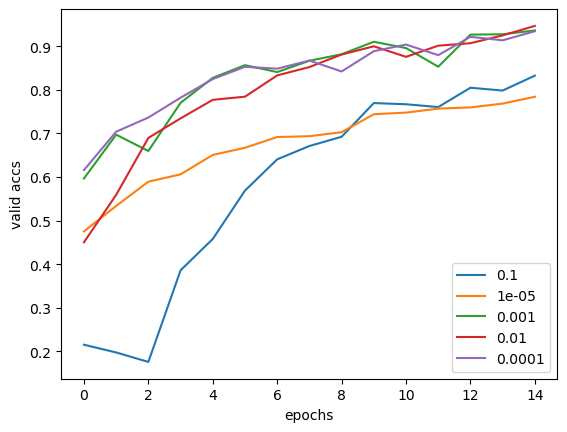

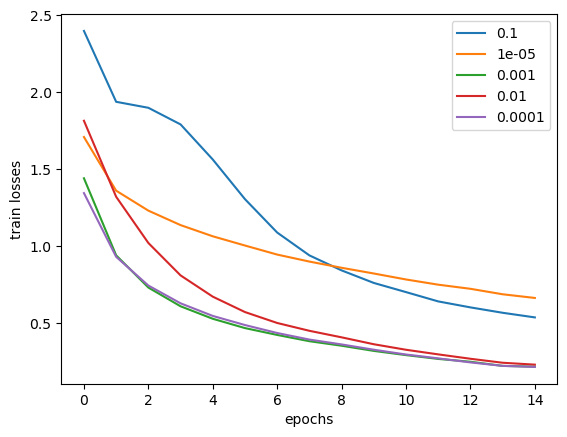

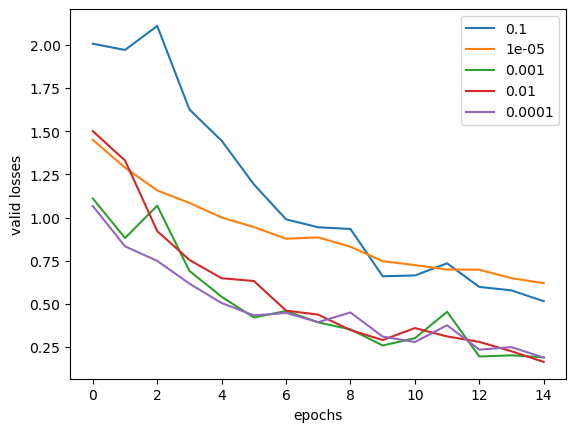

In [21]:
parent_dir = './model_configs/experiments/resnet18/resnet18'

from utils import generate_plots
list_dir = os.listdir(parent_dir)
list_dir = [os.path.join(parent_dir,f'{path}') for path in list_dir]
lrs_str = [os.path.split(directory)[-1] for directory in list_dir]
generate_plots(list_dir,lrs_str,save_path='./model_configs/experiments/resnet18/')


In [10]:
all_blocks = [2,4]
all_activations = ['gelu','relu']
all_dimensions = [128,512]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/MLP_mixer_optimal/mlpmixer_num_blocks_2_dim_128_gelu.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	128
num_blocks:	2
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 288906 total parameters, of which 288906 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.40741
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.74646
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.56670
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.40358
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.22474
== [TRAIN] Epoch: 0, Accuracy: 0.404 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.42581
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.506 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.41629
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.39942
[TRAIN] E

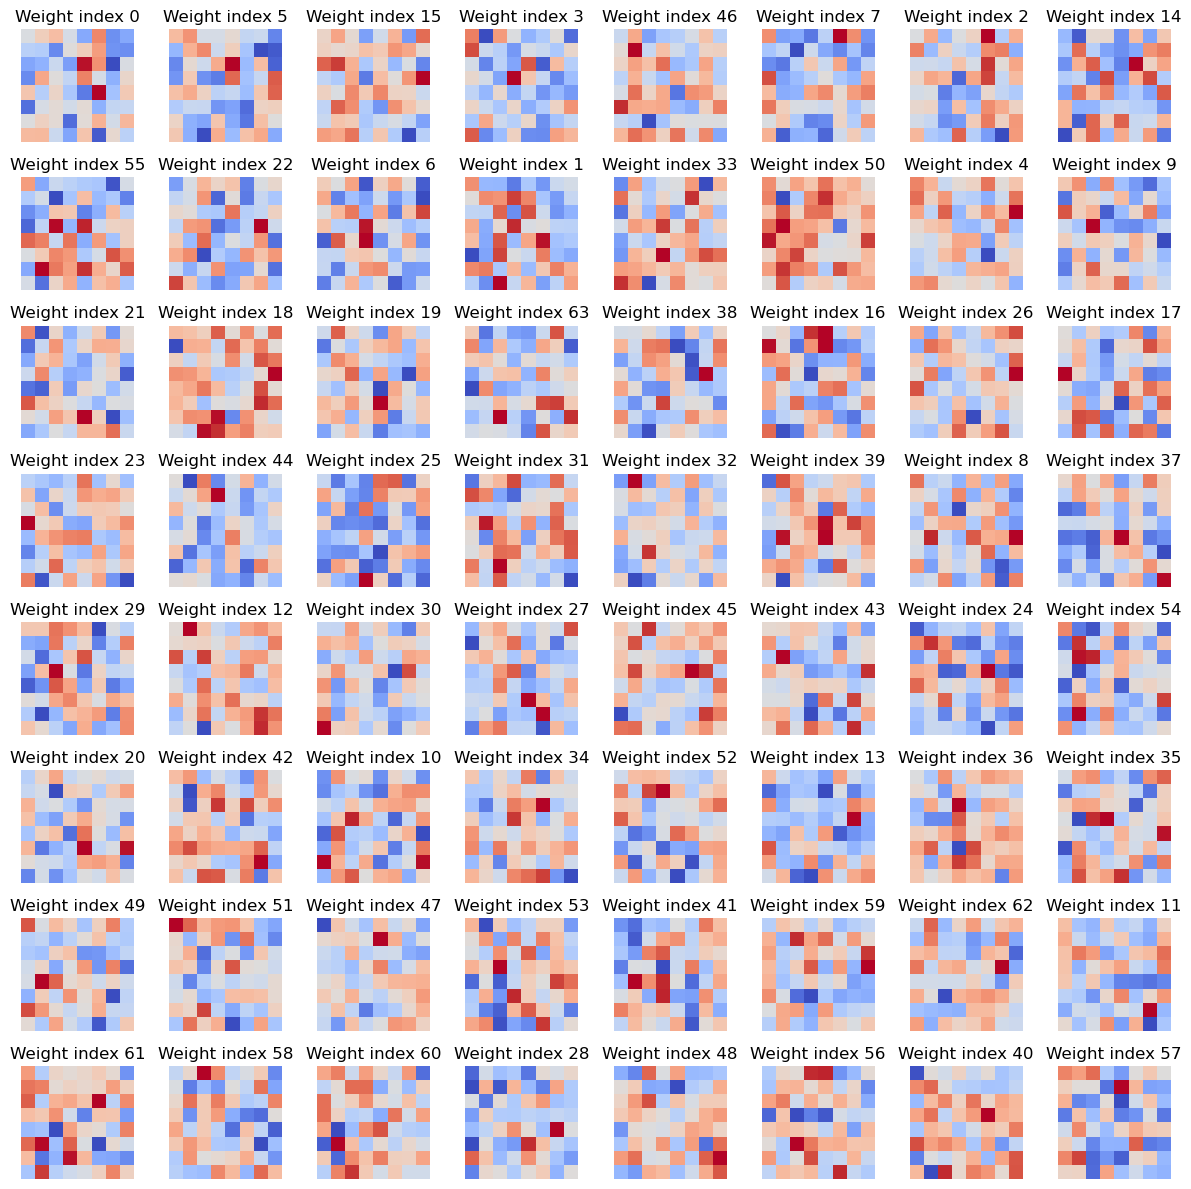

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/MLP_mixer_optimal/mlpmixer_num_blocks_2_dim_512_gelu.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	512
num_blocks:	2
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 4300938 total parameters, of which 4300938 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.39935
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.83801
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.55958
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.42712
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.15064
== [TRAIN] Epoch: 0, Accuracy: 0.416 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.52234
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.523 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.26274
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.19814
[TRAIN]

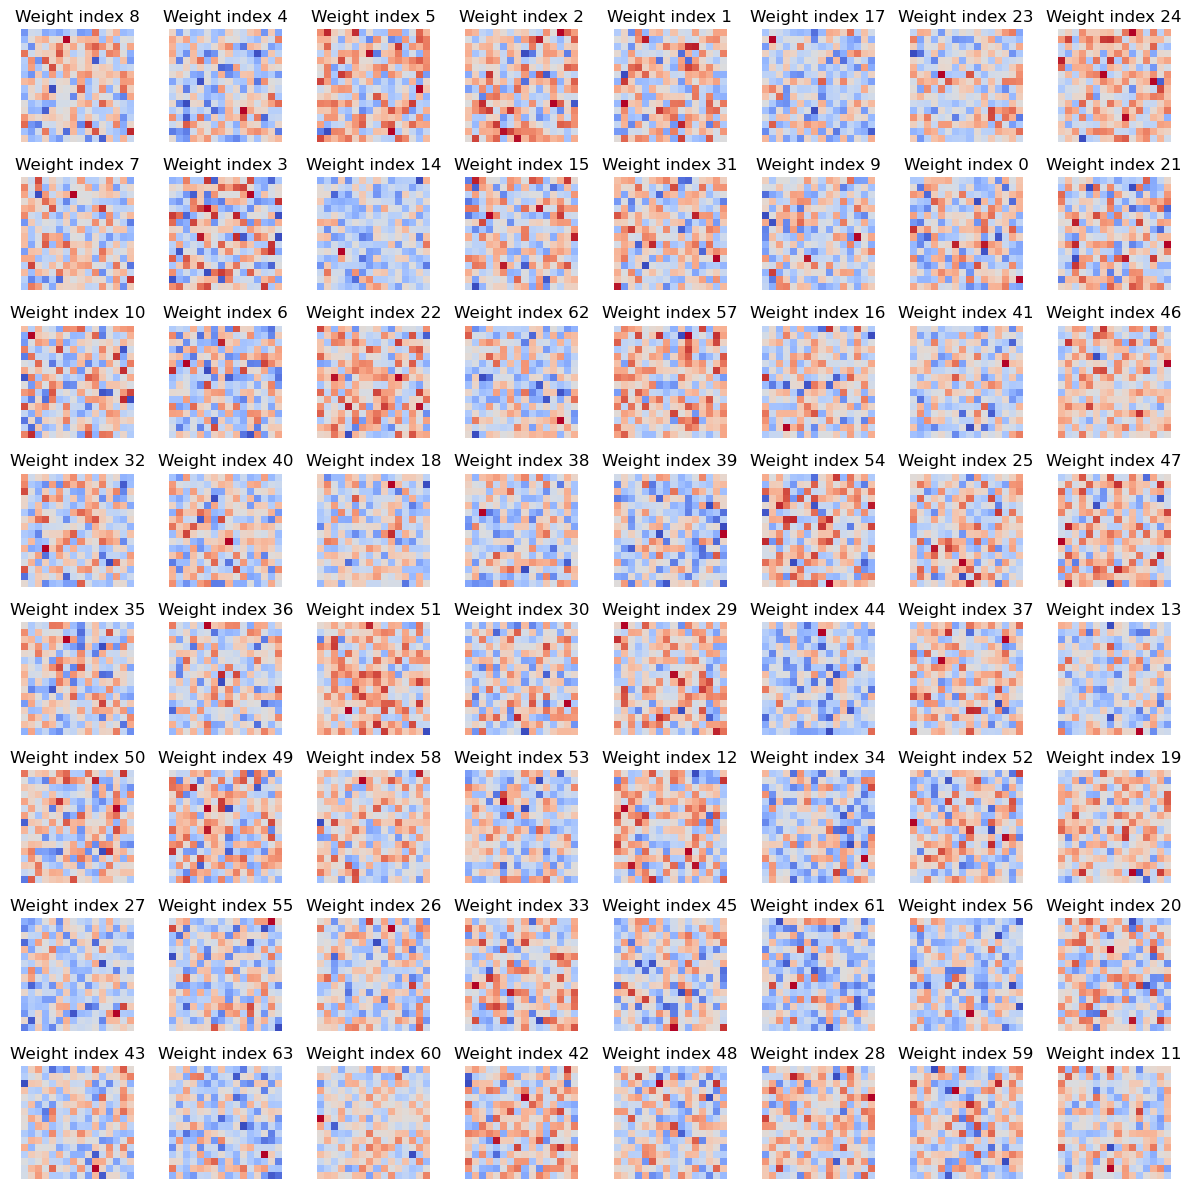

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/MLP_mixer_optimal/mlpmixer_num_blocks_2_dim_128_relu.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	128
num_blocks:	2
drop_rate:	0.0
activation:	relu
############################################
Initialized MLPMIXER model with 288906 total parameters, of which 288906 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.47976
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.80249
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.62495
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.51268
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.29409
== [TRAIN] Epoch: 0, Accuracy: 0.381 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.45311
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.496 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.46494
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.38453
[TRAIN] E

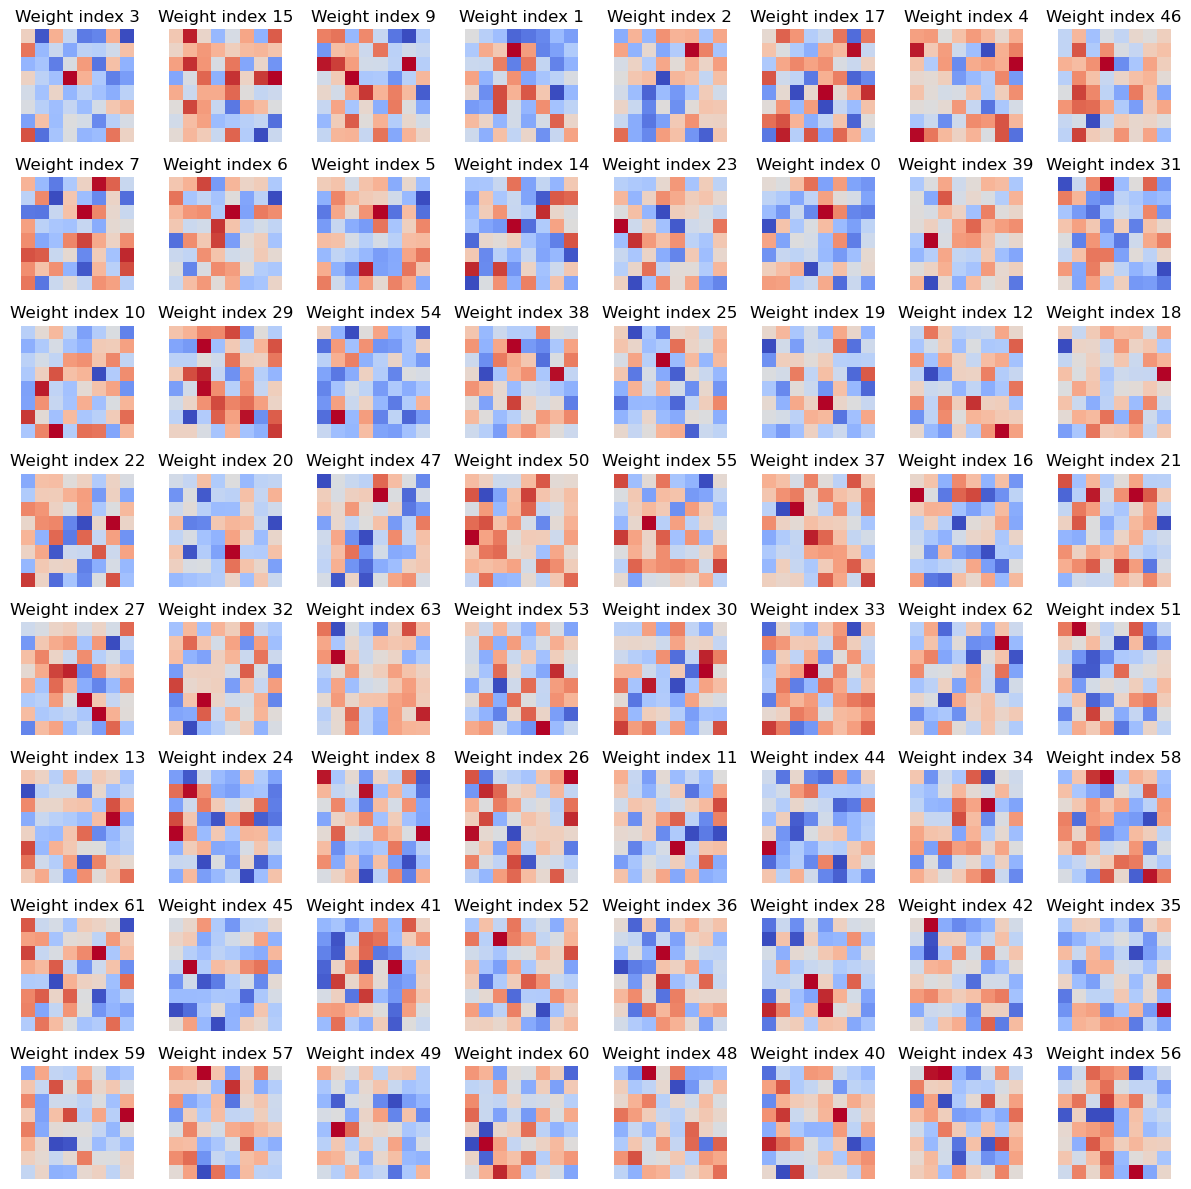

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/MLP_mixer_optimal/mlpmixer_num_blocks_2_dim_512_relu.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	512
num_blocks:	2
drop_rate:	0.0
activation:	relu
############################################
Initialized MLPMIXER model with 4300938 total parameters, of which 4300938 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.46721
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.91303
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.64232
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.45910
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.32273
== [TRAIN] Epoch: 0, Accuracy: 0.385 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.57473
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.490 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.29053
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.29767
[TRAIN]

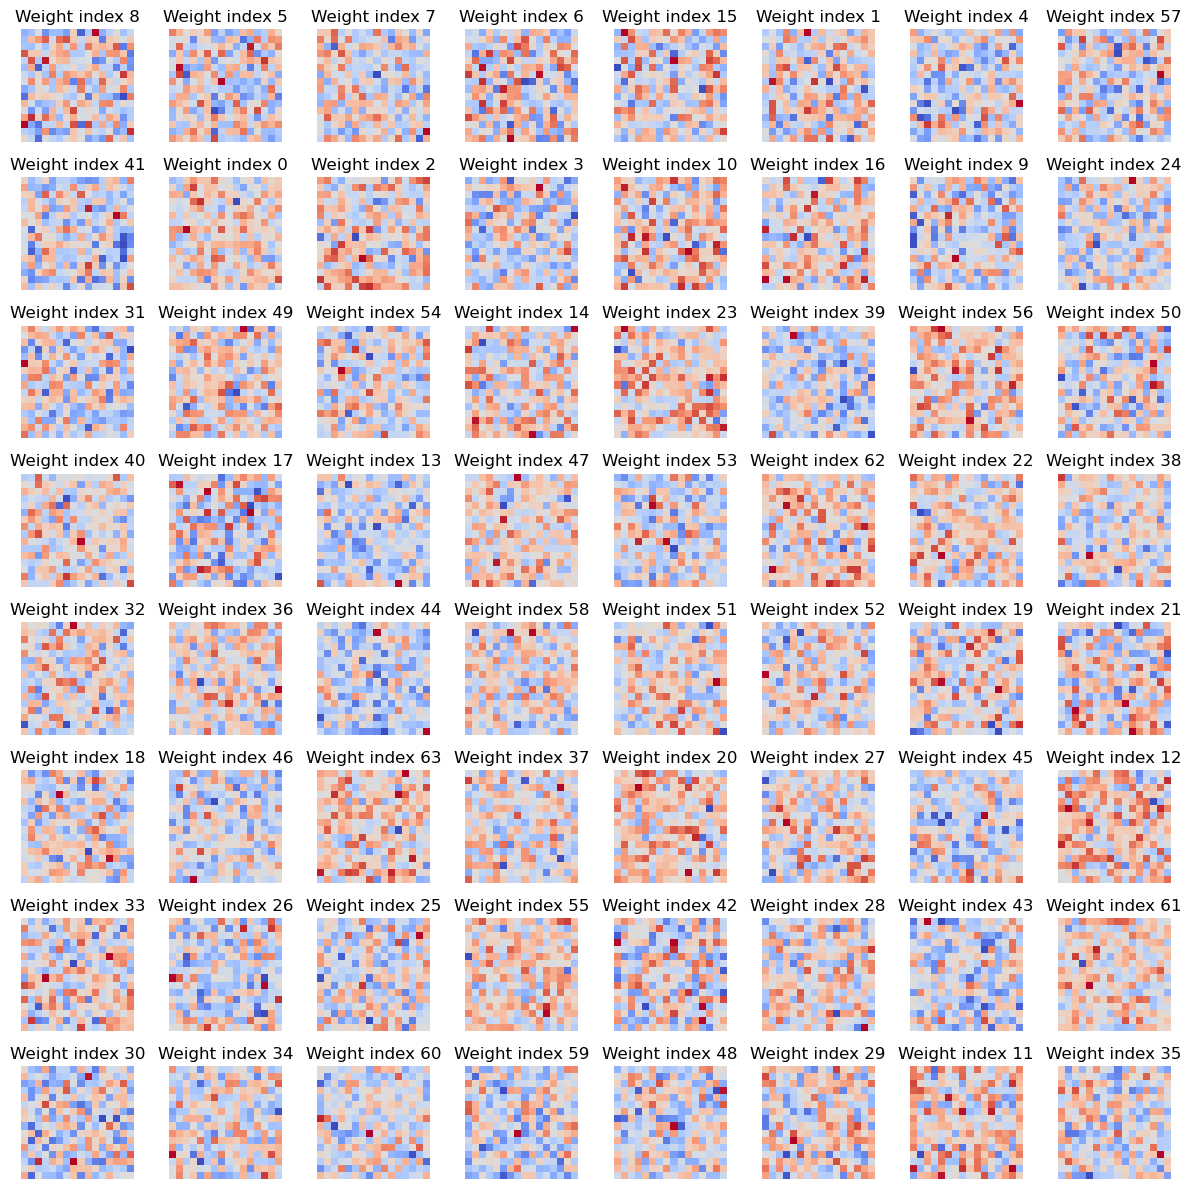

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/MLP_mixer_optimal/mlpmixer_num_blocks_4_dim_128_gelu.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	128
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 569994 total parameters, of which 569994 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.25772
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.79803
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.64717
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.42789
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.34173
== [TRAIN] Epoch: 0, Accuracy: 0.418 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.37263
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.529 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.24615
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.20785
[TRAIN] E

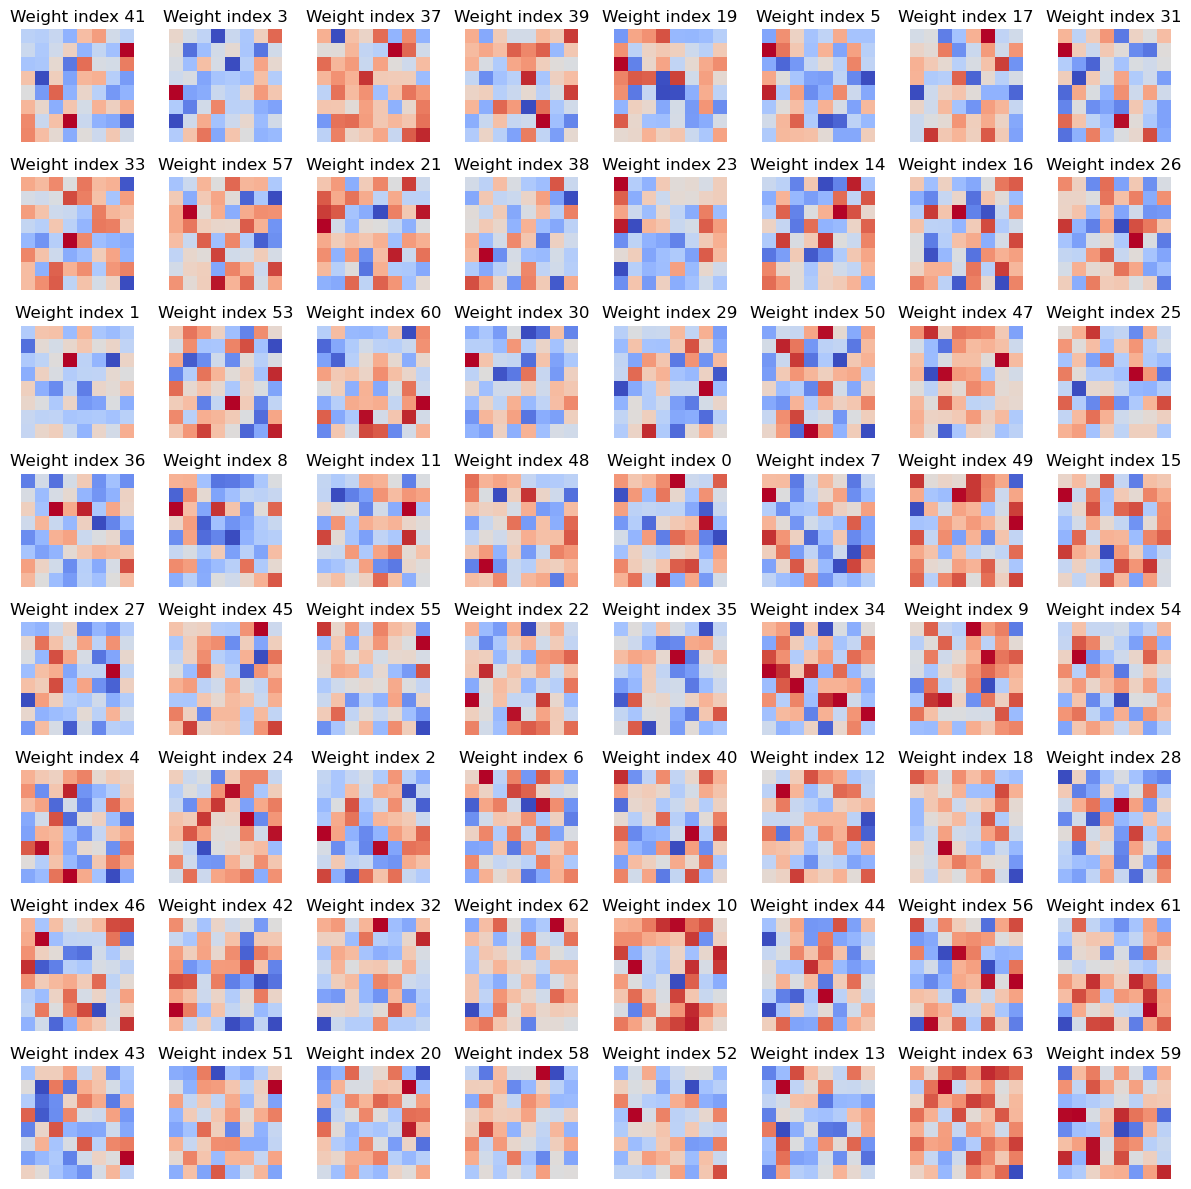

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/MLP_mixer_optimal/mlpmixer_num_blocks_4_dim_512_gelu.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	512
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 8570634 total parameters, of which 8570634 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.55152
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.76156
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.61933
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.49338
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.49612
== [TRAIN] Epoch: 0, Accuracy: 0.400 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.46041
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.498 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.37248
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.31598
[TRAIN]

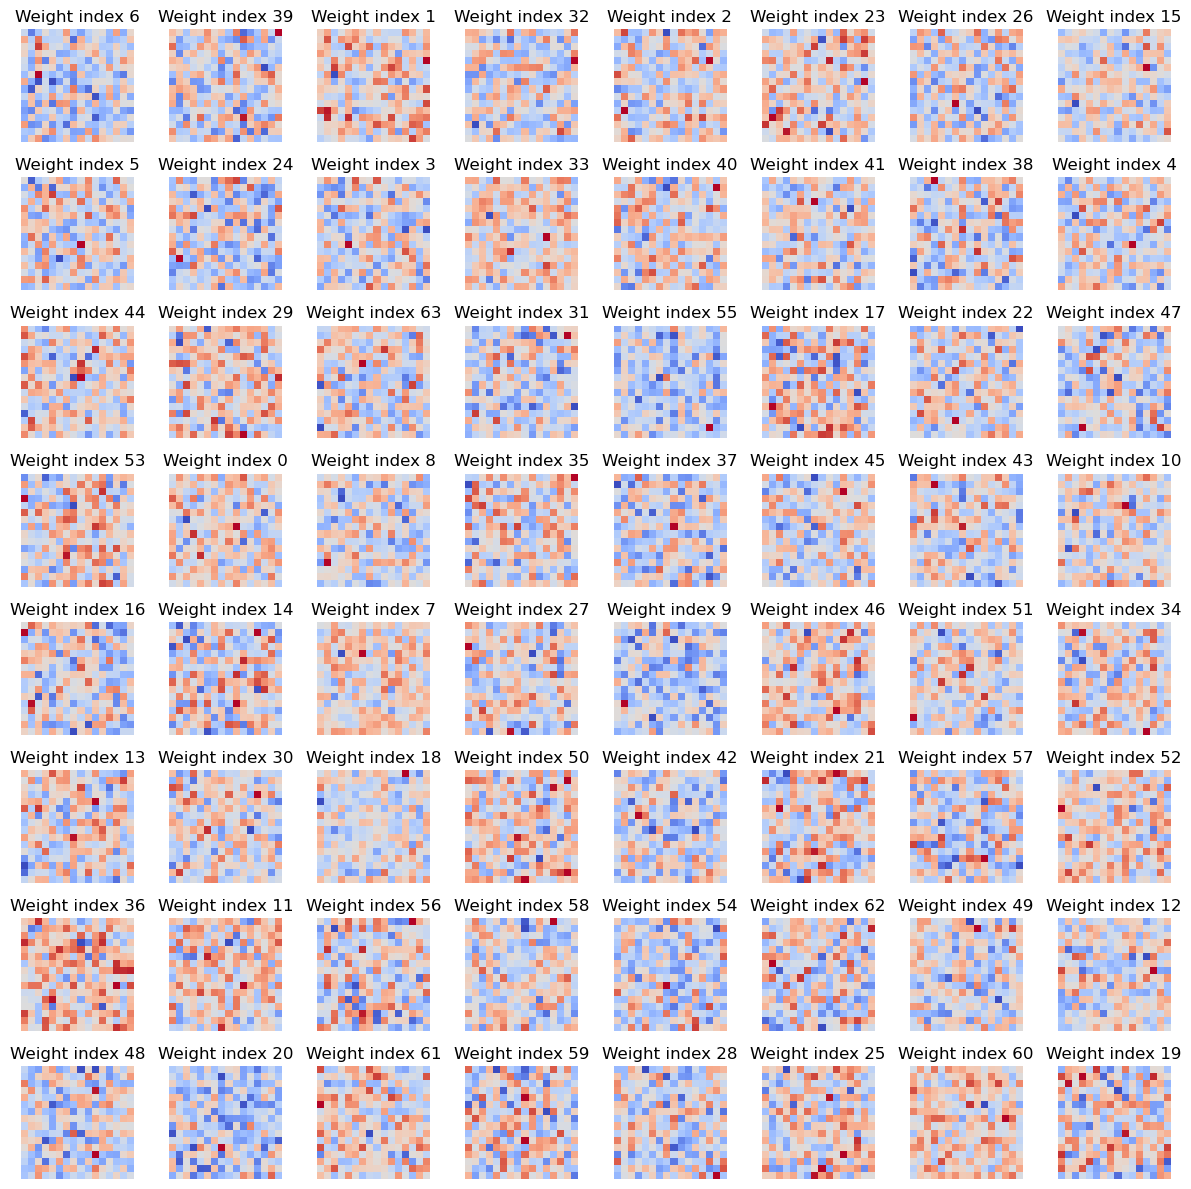

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/MLP_mixer_optimal/mlpmixer_num_blocks_4_dim_128_relu.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	128
num_blocks:	4
drop_rate:	0.0
activation:	relu
############################################
Initialized MLPMIXER model with 569994 total parameters, of which 569994 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.28220
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.93806
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.70787
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.46624
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.41945
== [TRAIN] Epoch: 0, Accuracy: 0.400 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.43152
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.507 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.33709
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.24504
[TRAIN] E

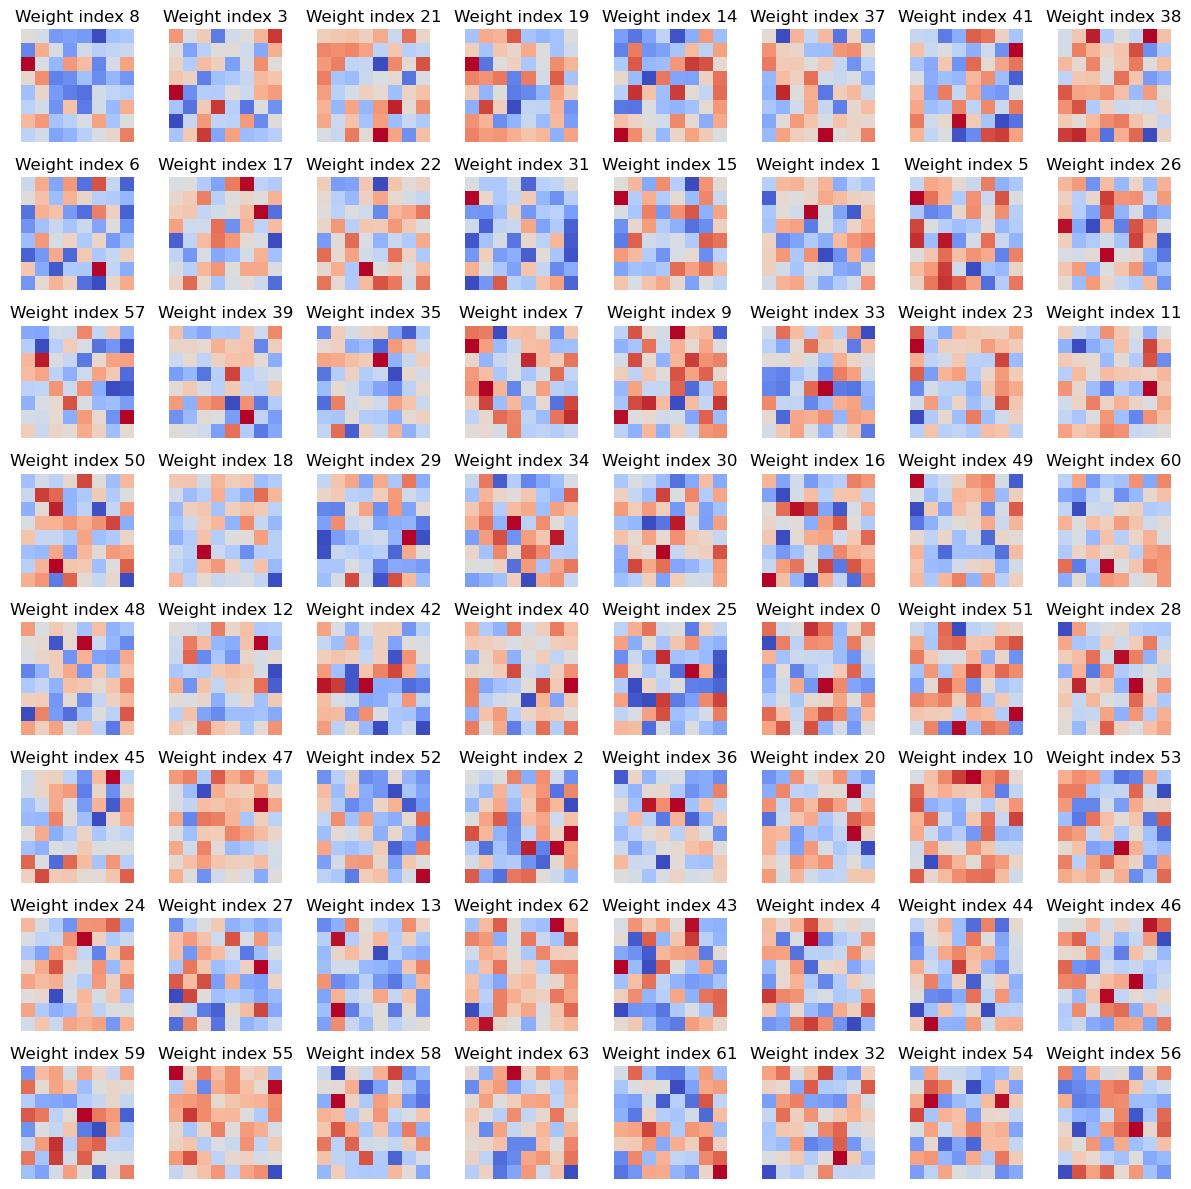

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/MLP_mixer_optimal/mlpmixer_num_blocks_4_dim_512_relu.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	512
num_blocks:	4
drop_rate:	0.0
activation:	relu
############################################
Initialized MLPMIXER model with 8570634 total parameters, of which 8570634 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.63547
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.92330
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.68151
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.53575
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.45080
== [TRAIN] Epoch: 0, Accuracy: 0.357 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.55898
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.485 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.46423
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.36162
[TRAIN]

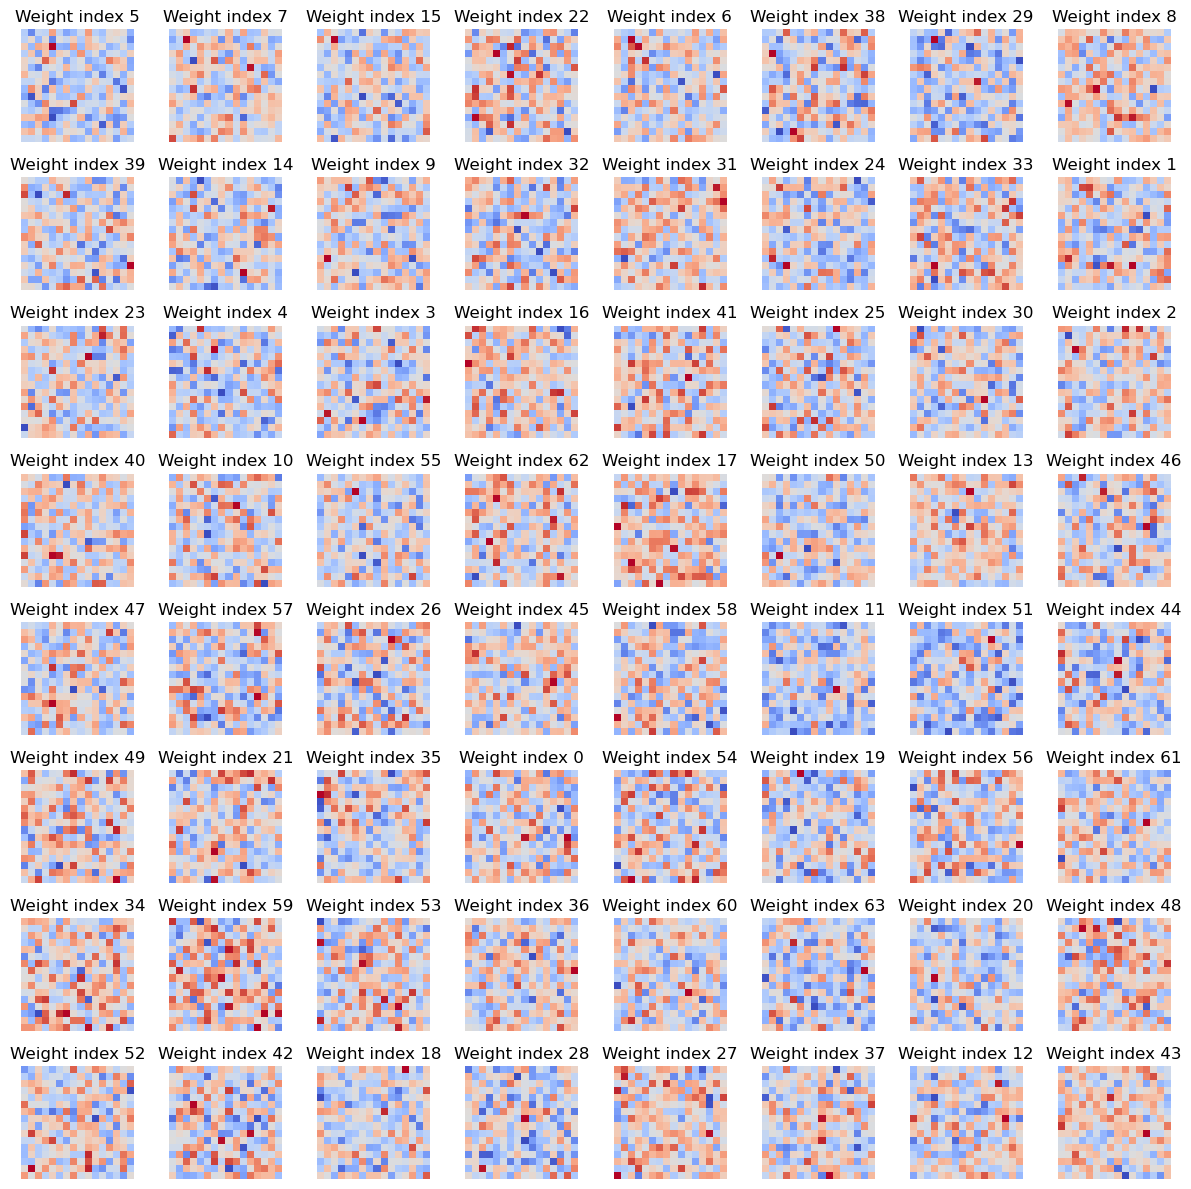

In [11]:
for block in all_blocks:
    for activation in all_activations:
        for dimension in all_dimensions:

            config_dir = f'./model_configs/MLP_mixer_optimal/mlpmixer_num_blocks_{block}_dim_{dimension}_{activation}.json'
            save_path = f'./model_configs/experiments/mlpmixer/optimal/mlpmixer_num_blocks_{block}_dim_{dimension}_{activation}'
            os.makedirs(save_path,exist_ok=True)
            config = Arguments(model='mlpmixer', 
                            model_config=config_dir, 
                            logdir=save_path,
                            visualize=True,
                            
                            
                            device='cuda',
                            )
            main_entry(config)

In [17]:
m = MLPMixer(num_classes=10,img_size=32,patch_size=4,embed_dim=128,num_blocks=4)

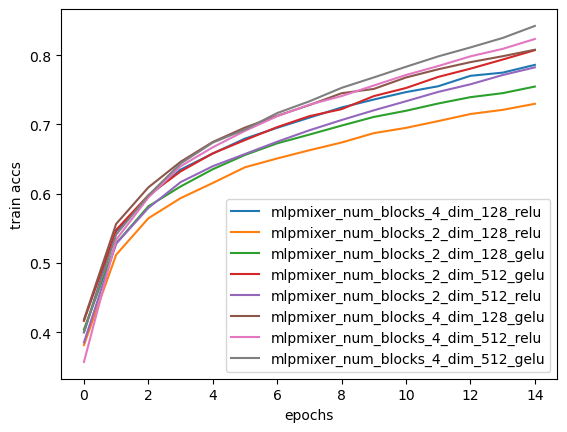

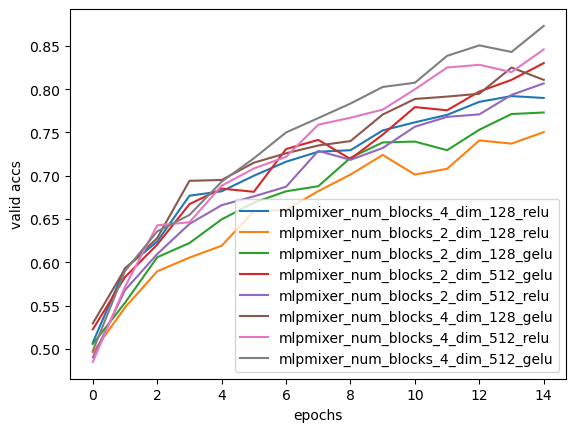

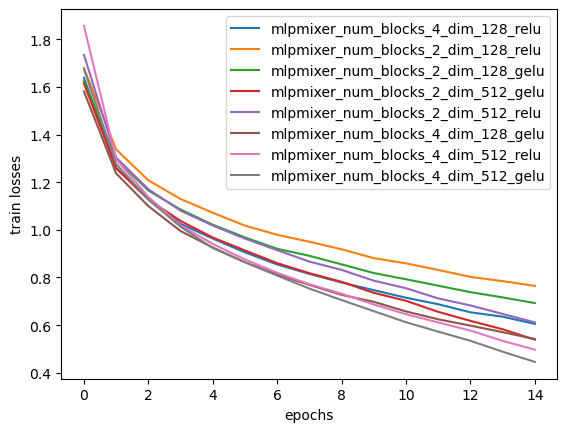

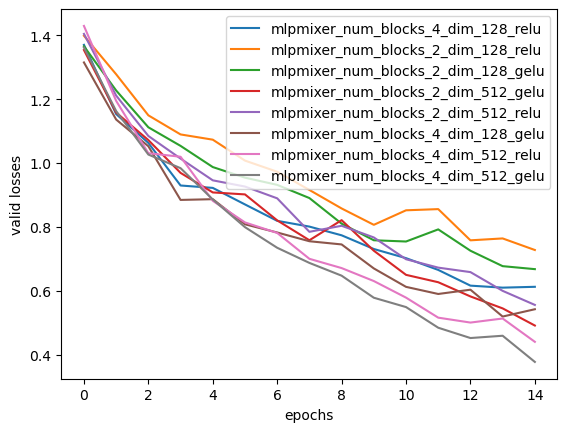

In [12]:
parent_dir = './model_configs/experiments/mlpmixer/optimal/'

from utils import generate_plots
list_dir = os.listdir(parent_dir)
list_dir = [os.path.join(parent_dir,f'{path}') for path in list_dir]
lrs_str = [os.path.split(directory)[-1] for directory in list_dir]
generate_plots(list_dir,lrs_str,save_path=parent_dir)


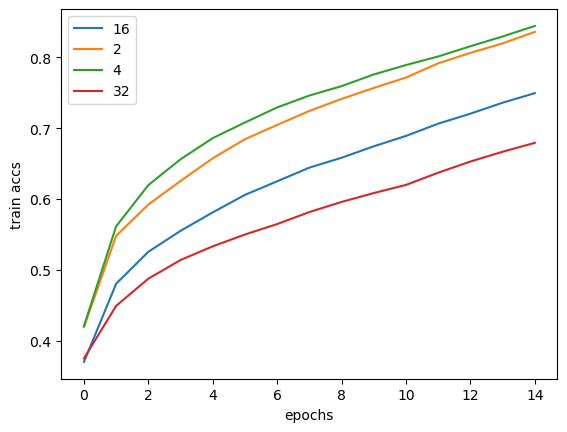

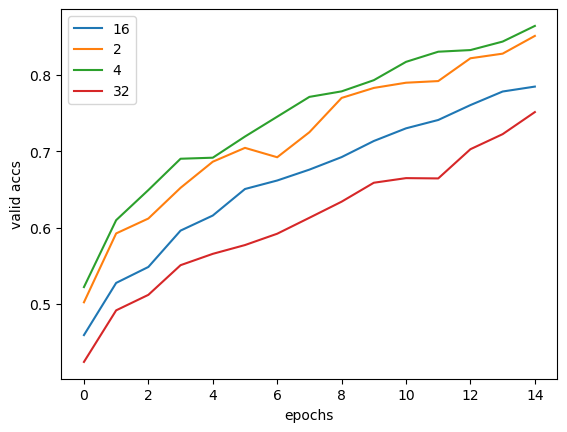

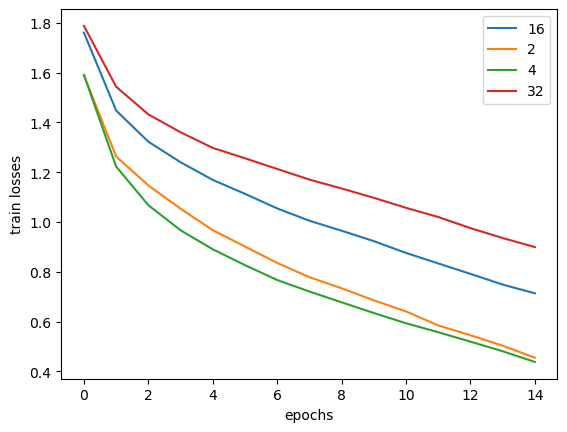

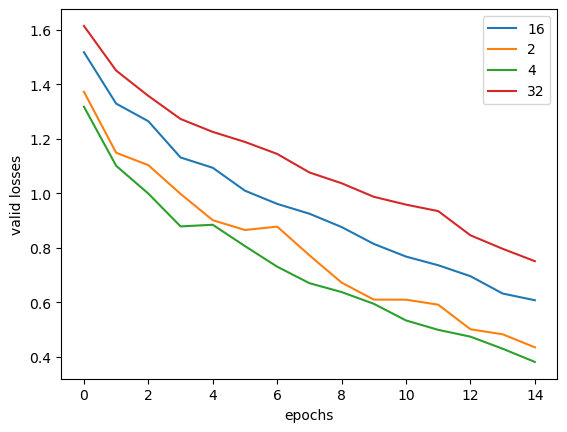

In [7]:
parent_dir = './model_configs/experiments/mlpmixer/patch_sizes/'

from utils import generate_plots
list_dir = os.listdir(parent_dir)
list_dir = [os.path.join(parent_dir,f'{path}') for path in list_dir]
lrs_str = [os.path.split(directory)[-1] for directory in list_dir]
generate_plots(list_dir,lrs_str,save_path=parent_dir)


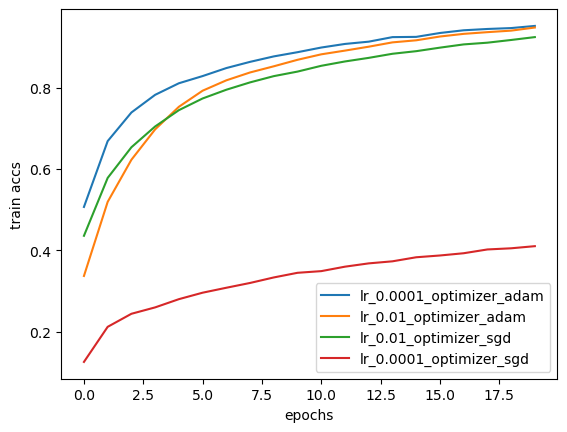

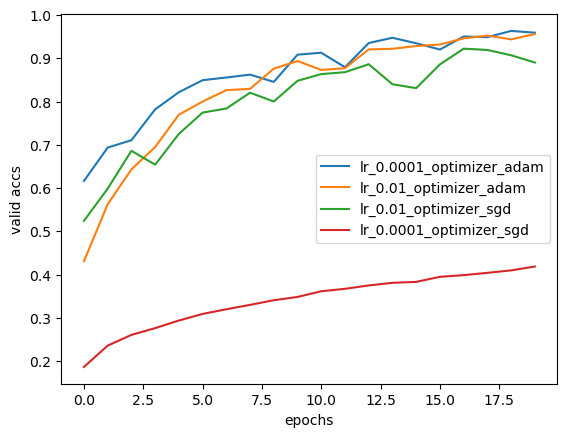

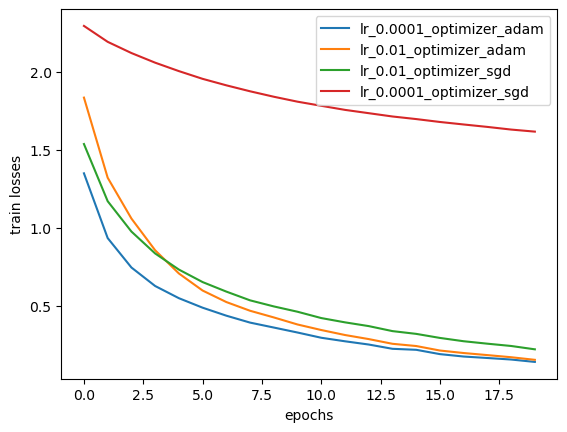

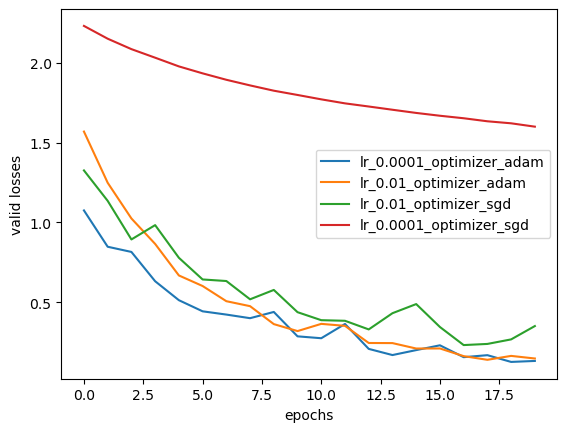

In [10]:
parent_dir = '/home/ozhan/IFT6135/IFT6135-2025/HW1_2025/assignment1_release/model_configs/experiments/resnet18/optimal'

from utils import generate_plots
list_dir = os.listdir(parent_dir)
list_dir = [os.path.join(parent_dir,f'{path}') for path in list_dir]
lrs_str = [os.path.split(directory)[-1] for directory in list_dir]
generate_plots(list_dir,lrs_str,save_path=parent_dir)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer128.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	128
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 569994 total parameters, of which 569994 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.25772
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.79803
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.64717
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.42789
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.34173
== [TRAIN] Epoch: 0, Accuracy: 0.418 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.37263
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.529 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.24615
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.20785
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.28469
[TRAIN]

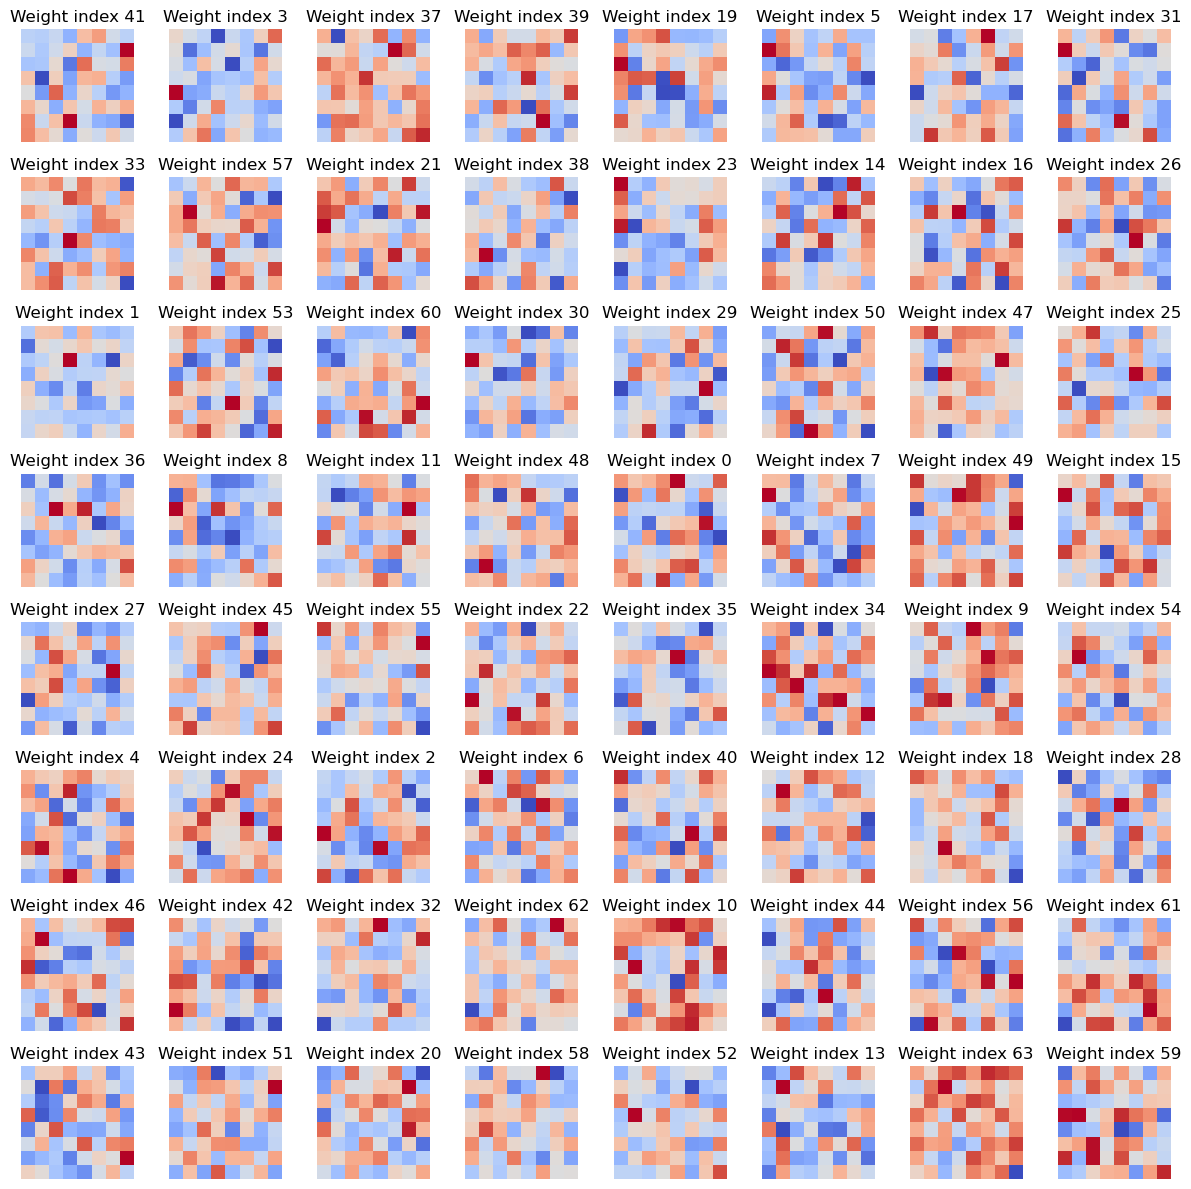

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer256.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 2188298 total parameters, of which 2188298 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.31901
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.57623
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.61766
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.41238
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.47204
== [TRAIN] Epoch: 0, Accuracy: 0.421 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.39669
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.522 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.21684
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.32808
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.19022
[TRAI

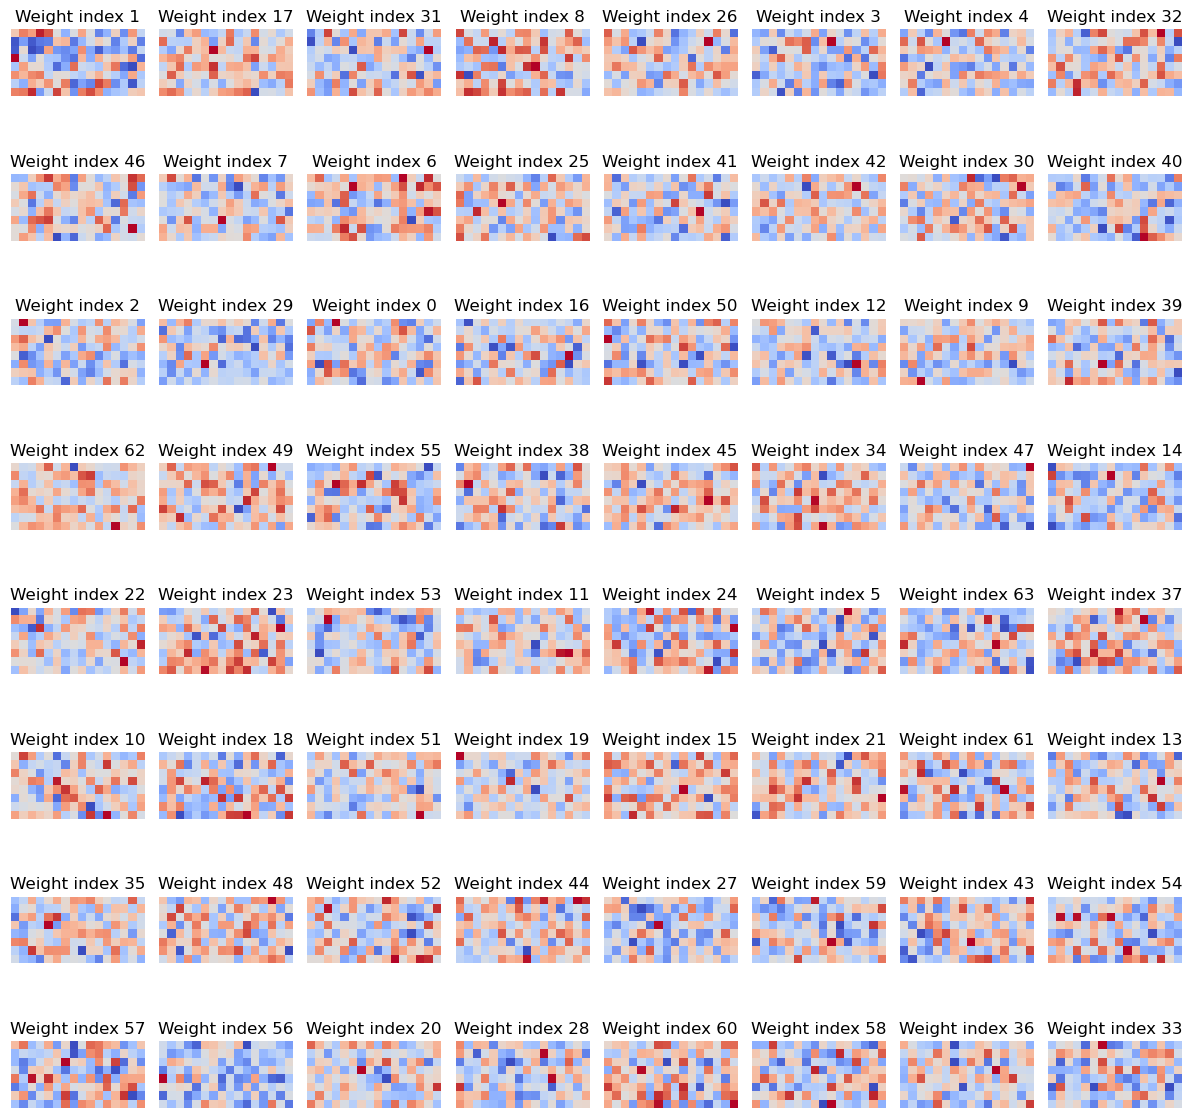

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer512.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	512
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 8570634 total parameters, of which 8570634 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.55152
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.76156
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.61930
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.49346
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.49597
== [TRAIN] Epoch: 0, Accuracy: 0.400 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.46035
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.498 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.37232
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.31575
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.42554
[TRAI

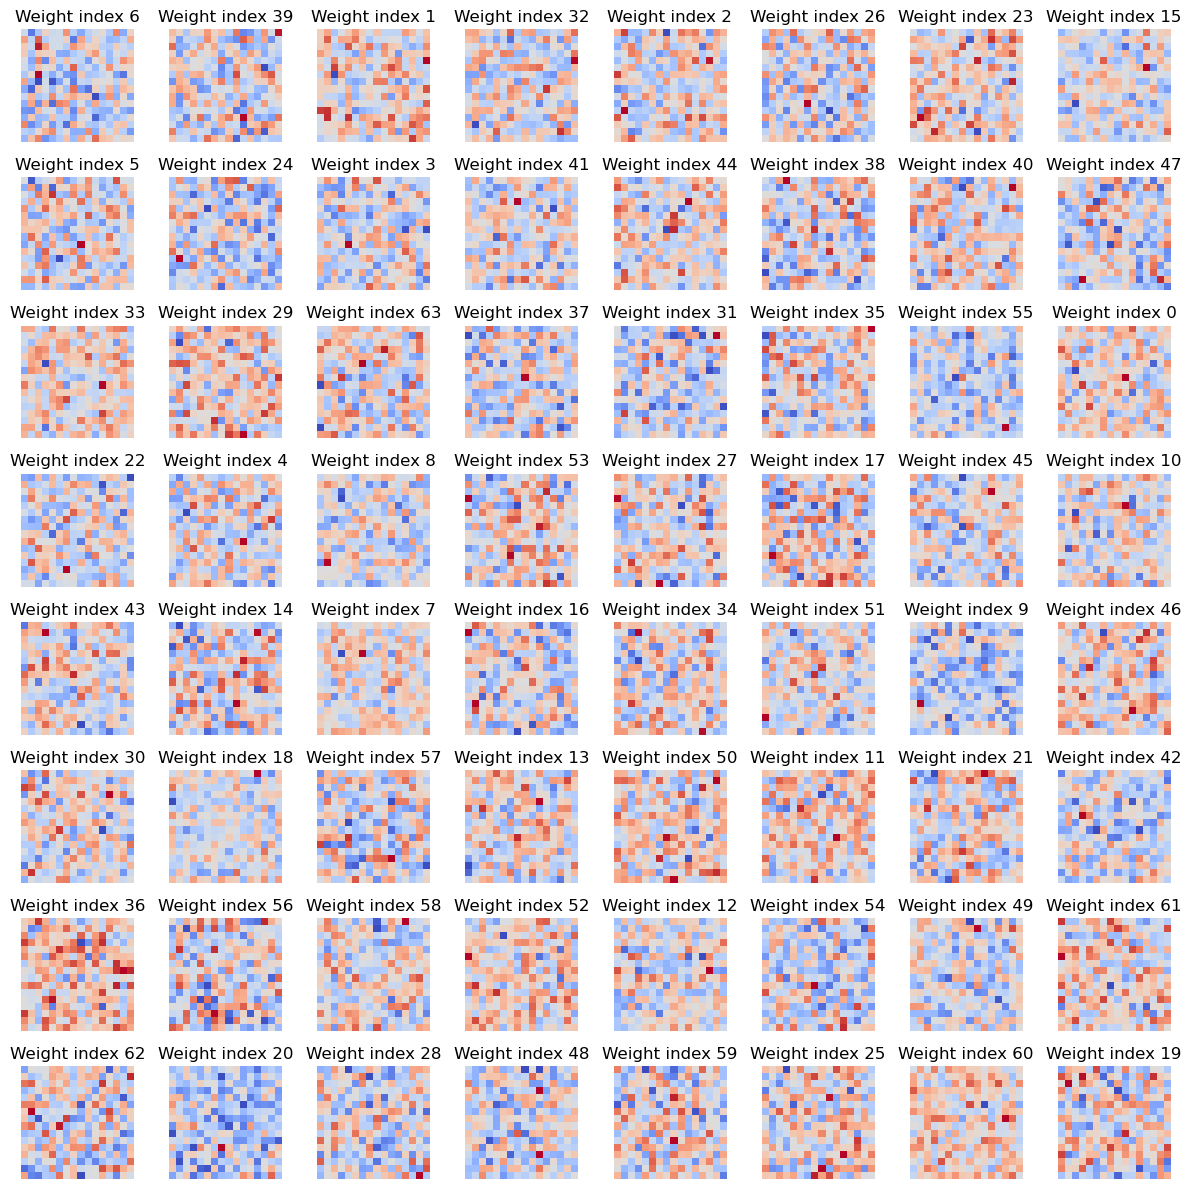

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer1024.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	1024
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 33918218 total parameters, of which 33918218 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.55239
[TRAIN] Epoch: 0, Iter: 80, Loss: 2.02357
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.94783
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.65100
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.48188
== [TRAIN] Epoch: 0, Accuracy: 0.318 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.57123
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.442 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.42096
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.29750
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.49767
[

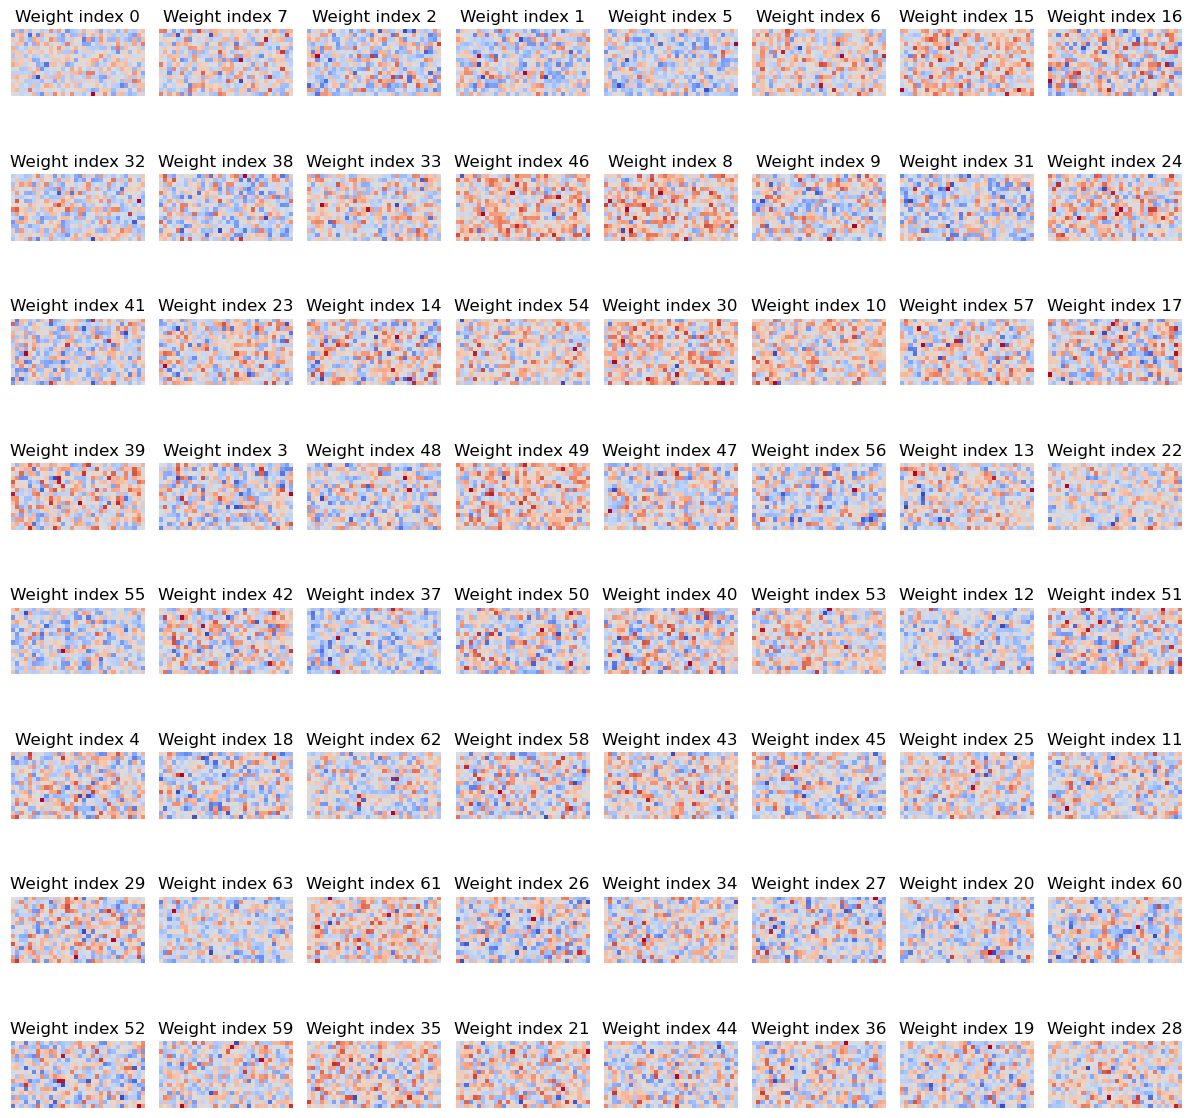

In [6]:
widths = [128,256,512,1024]
for width in widths:
    config_dir = f'./model_configs/mlpmixer{width}.json'
    save_path = f'./model_configs/experiments/mlpmixer/widths/widht_{width}'
    config = Arguments(model='mlpmixer', 
                                model_config=config_dir, 
                                logdir=save_path,
                                visualize=True,                       
                                device='cuda',
                                )
    main_entry(config)